In [ ]:
import torch
from lhotse import CutSet

In [ ]:
# lhotse.load_manifest
# cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts.jsonl.gz")
# cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_original_supervisions.jsonl.gz")
# cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_15s.jsonl.gz")
# cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_30s.jsonl.gz")
# cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_45s.jsonl.gz")
cuts = CutSet.from_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_30s_multi_speaker.jsonl.gz")
cuts = cuts.to_eager()
cuts.describe()

In [ ]:
random_cuts = cuts.sample(n_cuts=2)
# random_cuts = [cuts["SBC001_1249170_1250640_LYNNE"]]
# random_cuts = [cuts["SBC003_0009060_0009510_MARILYN"]]
# random_cuts = [cuts["4344338_321"]]
# random_cuts = [cuts["4360717_425"]]
cid = random_cuts[0].id

# cuts = cuts.to_eager()
# # id = 12
# # cid = f'session{id}_speaker{id}_{id}'
# cid = "LRLCF_2020_Q4_20210211_00-15-31-770_00-15-39-570_111"
# random_cuts = [cuts[cid]]

random_cut = random_cuts[0]
print(random_cut)
print(random_cut.supervisions[0].text)
print(random_cut.custom)
# random_cut.plot_audio()
random_cut.play_audio()

In [ ]:
a = random_cut.load_audio()

In [ ]:
a.shape

### No cutset

In [1]:
import torch
import torchaudio

In [18]:
audio_path = "/scratch4/skhudan1/rhuang25/data/seekingalpha/audio2019/705/4235705.mp3"
waveform, sample_rate = torchaudio.load(audio_path)

In [5]:
print(waveform.shape)
print(sample_rate)

torch.Size([1, 5387616])
24000


In [19]:
# waveform = waveform[:,:5387616]
waveform = waveform[:,:253876]

In [20]:
tensor = waveform
total_size = tensor.element_size() * tensor.nelement()
print(f"{total_size / 1024 / 1024} MB")

0.9684600830078125 MB


### Some helper functions.

In [6]:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

In [24]:
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

### vis by torchaudio

In [ ]:
waveform, sample_rate = torch.from_numpy(random_cut.load_audio()), random_cut.recording.sampling_rate

In [ ]:
random_cut

In [21]:
# print(random_cut.supervisions[0].text)
play_audio(waveform, sample_rate)

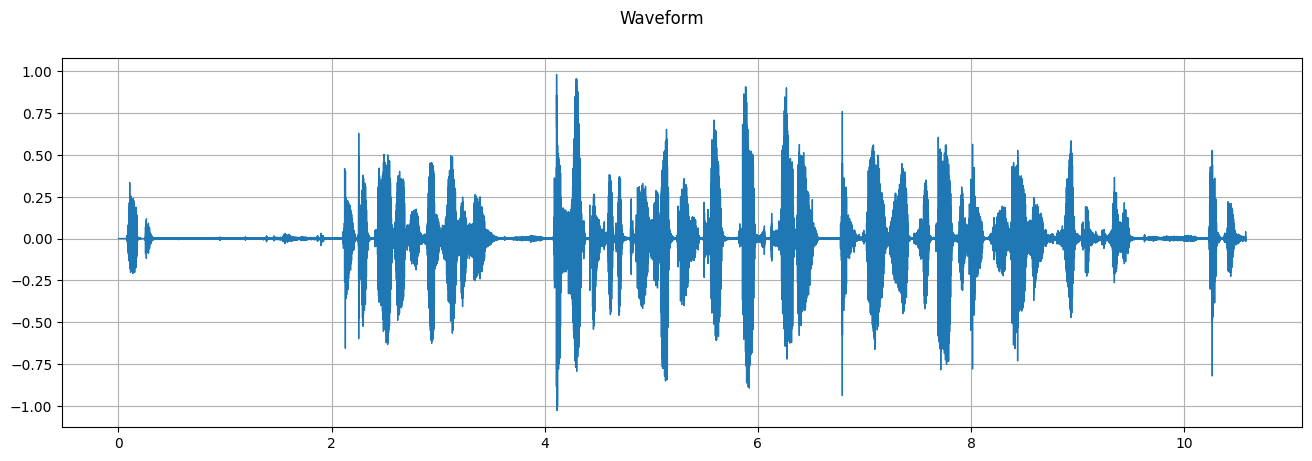

In [25]:
plot_waveform(waveform, sample_rate)

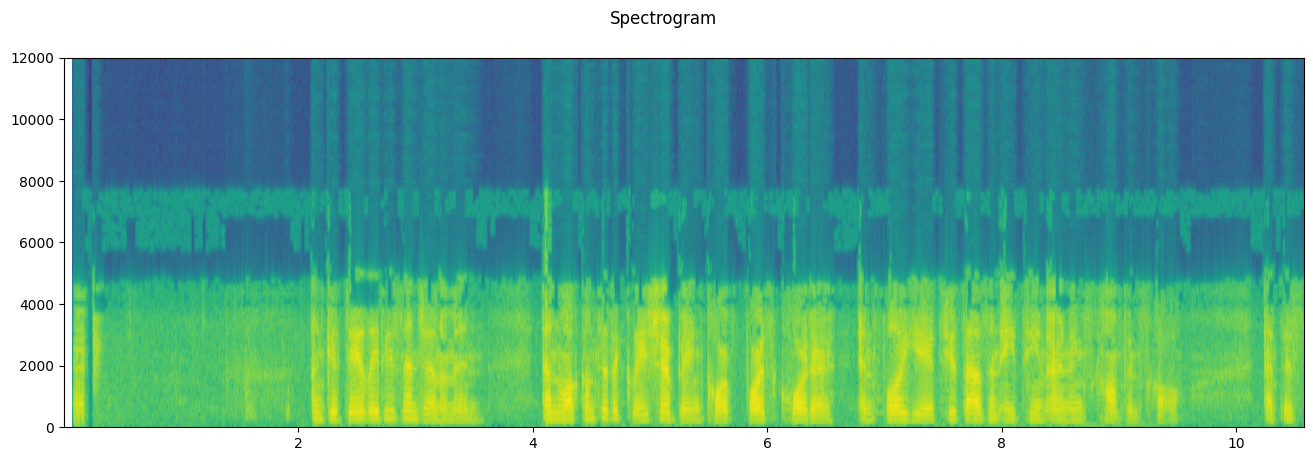

In [26]:
plot_specgram(waveform, sample_rate)


In [ ]:
# Play two channels seperately, e.g., SBC006_0217730_0218930_ALINA
play_audio(waveform[:1], sample_rate)

In [ ]:
play_audio(waveform[0:], sample_rate)

In [ ]:
# Merge two channels
random_cut1 = random_cut.to_mono(mono_downmix=True)
waveform, sample_rate = torch.from_numpy(random_cut1.load_audio()), random_cut1.recording.sampling_rate

### Reduce channels and sampling rate

In [ ]:
from tqdm import tqdm
from lhotse import RecordingSet
from pathlib import Path

root_dir = Path("/expscratch/mmaciejewski/temp/sbcsae_wip_lhotse_prep/")
recording_set = RecordingSet.from_file(root_dir / "sbcsae_recordings.jsonl")

sampling_rate = 16000
recording_set = recording_set.resample(sampling_rate)

for r in tqdm(recording_set):
    storage_path = f'/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/recordings_resampled/{r.sources[0].source.split("/")[-1]}'
    if Path(storage_path).exists():
        continue
    
    c = r.to_cut()
    if len(r.sources[0].channels) > 1:
        c = c.to_mono(mono_downmix=True)
    c.save_audio(storage_path)

In [ ]:
# %s/\/export\/fs04\/a12\/rhuang\/icefall_align2\/egs\/librispeech\/ASR\/download/\/exp\/rhuang\/librispeech\/download2/g

In [ ]:
cuts.to_file("/exp/rhuang/meta/audio_ruizhe/santa-barbara-corpus/data/sbc_cuts_multi_channels.jsonl.gz")